### Building the Dataset

In [1]:
words = open('/names.txt').read().splitlines()

In [3]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
vocab = ['.'] + sorted(set([letter for word in words for letter in word]))
stoi = {s:i for i, s in enumerate(vocab)}
itos = {i:s for i, s in enumerate(vocab)}

print(vocab)
print()
print(stoi)
print()
print(itos)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [9]:
xs, ys = [], []
context_size = 3

for word in words:
  prefix = ''.join(context_size * ['.'])
  suffix = '.'
  word = prefix + word + suffix

  loop_freq = len(word) - context_size

  for i in range(loop_freq):
    context = word[i:i+context_size]
    target = word[i+context_size]

    xs.append([stoi[chr] for chr in context])
    ys.append(stoi[target])

import torch
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [10]:
print(xs)
print(ys)

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


### Building network: Forward pass and loss calculation

In [11]:
import torch
embedding_size = 2
# Creating the embedding lookup table
C = torch.randn((27, embedding_size))

# Converting all inputs to embeddings
x = C[xs]

# Layer 1 - initializing weights
W1 = torch.randn((context_size*embedding_size, 100))  # (inputs, outputs)
b1 = torch.randn(100)

# Layer 1 - computation
z1 = x.view(-1, context_size*embedding_size) @ W1 + b1
h1 = torch.tanh(z1)  # 100 dimensional output for each input example

# Layer 2 - initializing weights
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

# Layer 2 - computation
logits = h1 @ W2 + b2
counts = torch.exp(logits)
probs = counts / counts.sum(dim=1, keepdim=True)

print(probs.shape)

torch.Size([228146, 27])


In [12]:
# implementing negative log likelihood
loss = -probs[torch.arange(len(xs)), ys].log().mean().item()
print(f'loss: {loss}')

# torch way to calculate the loss:
import torch.nn.functional as F
loss_ = F.cross_entropy(logits, ys)
print(f'loss: {loss_}')

# Using F.cross_entropy: Advantages
# 1. Things can be much more numerically well behaved
# 2. Forward pass is much more efficient [unnecessary intermediary tensors are not created]
# 3. Backward pass is much more efficient [function is implemented in such a way that we can calculate
#    gradient with respect to input just in one step]

loss: 15.614145278930664
loss: 15.614143371582031


### Writing training loop

In [13]:
# initializations:

# Creating the embedding lookup table - initializing weights for layer 0
embedding_size = 2
C = torch.randn((27, embedding_size))

# Layer 1 - initializing weights
W1 = torch.randn((context_size*embedding_size, 100))  # (inputs, outputs)
b1 = torch.randn(100)


# Layer 2 - initializing weights
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

# creating param list
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

In [14]:
lr = 0.01
# Loop
for _ in range(12):

  # minibatch construct
  ix = torch.randint(0, xs.shape[0], (1024,))

  # Embedding layer - Layer 0 computation
  x = C[xs[ix]]
  # Layer 1 - computation
  z1 = x.view(-1, context_size*embedding_size) @ W1 + b1
  h1 = torch.tanh(z1)  # 100 dimensional output for each input example
  # Layer 2 - computation
  logits = h1 @ W2 + b2
  counts = torch.exp(logits)
  probs = counts / counts.sum(dim=1, keepdim=True)
  loss_ = F.cross_entropy(logits, ys[ix])
  print(f'loss: {loss_.item()}')

  # backpass
  for p in params:
    p.grad = None
  loss_.backward()

  # learning rate decay
  lr = 0.05 if i < 100000 else 0.01

  # update
  n = 0
  for p in params:
    p.data += -lr * p.grad

loss: 17.51024627685547
loss: 17.019540786743164
loss: 15.985477447509766
loss: 15.121962547302246
loss: 14.047195434570312
loss: 13.58606243133545
loss: 12.849099159240723
loss: 12.818434715270996
loss: 12.721114158630371
loss: 12.162458419799805
loss: 11.799033164978027
loss: 11.75967025756836


### Writing trainig loop again: but this time, training on training set, and testing on validation/test sets

Also, obsever behaviour of loss with no. of iterations with a plot

In [41]:
# initializations:

# divide xs into train, test and val set
n1 = int(0.8 * len(xs))
n2 = int(0.9 * len(xs))

x_train, y_train = xs[0:n1], ys[0:n1]
x_dev, y_dev = xs[n1:n2], ys[n1: n2]
x_test, y_test = xs[n2:], ys[n2:]

# Creating the embedding lookup table - initializing weights for layer 0
embedding_size = 2
C = torch.randn((27, embedding_size))

# Layer 1 - initializing weights
W1 = torch.randn((context_size*embedding_size, 100))  # (inputs, outputs)
b1 = torch.randn(100)


# Layer 2 - initializing weights
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

# creating param list
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

In [42]:
lr = 0.01
stepi = []
lossi = []

# Loop
for _ in range(20000):

  # minibatch construct
  ix = torch.randint(0, xs.shape[0], (1024,))

  # Embedding layer - Layer 0 computation
  x = C[xs[ix]]
  # Layer 1 - computation
  z1 = x.view(-1, context_size*embedding_size) @ W1 + b1
  h1 = torch.tanh(z1)  # 100 dimensional output for each input example
  # Layer 2 - computation
  logits = h1 @ W2 + b2
  counts = torch.exp(logits)
  probs = counts / counts.sum(dim=1, keepdim=True)
  loss_ = F.cross_entropy(logits, ys[ix])

  # backpass
  for p in params:
    p.grad = None
  loss_.backward()

  # # learning rate decay
  # lr = 0.01 if i < 100000 else 0.01

  # update
  for p in params:
    p.data += -lr * p.grad

  # statistics for plotting
  stepi.append(_)
  lossi.append(loss_.item())

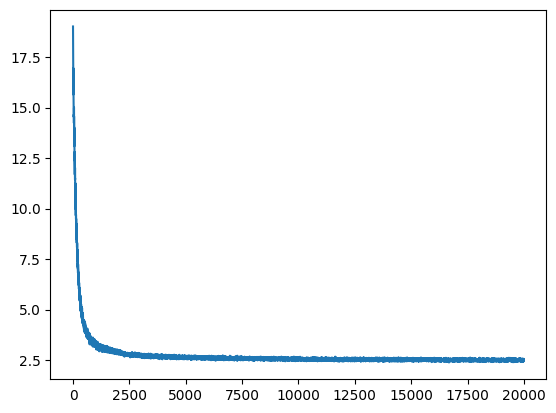

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(stepi, lossi)

In [44]:
emb = C[x_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_size*embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.4721, grad_fn=<NllLossBackward0>)

In [45]:
emb = C[x_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_size*embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.5807, grad_fn=<NllLossBackward0>)